In [1]:
# import useful libraries 
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
import time 

# data loading imports 
from data_utils import load_dataset

# Question 1: Implement K-NN for Regression

In [26]:
# define K_NN for regression algorithm, x_test contains multiple inputs 
def K_NN_Regression_Brute(x_train, y_train, x_test, k, distance_metric):
    # prediction will have same length as x_test, will be returned 
    predictions = np.zeros((x_test.shape[0], 1))
    i = 0 
    # loop through all the test points 
    for test_point in x_test:
        if distance_metric == 1:
            # use l1 distance  
            # apply reshape to ensure equal 2nd dimension as x_train is (__, 1)
            dist = np.sum(np.abs(x_train-test_point.reshape((1,-1))), axis=1) 
        elif distance_metric == 2:
            # use l2 distance 
            dist = np.sqrt(np.sum(np.square(x_train-test_point.reshape((1,-1))), axis=1))
        else:
            print('ERROR')
            return None
        # return the first nearest k point's indices 
        i_nn = np.argpartition(dist, kth=k)[:k]
        # calculate the mean of the y_train values for the k indices
        current_prediction = np.mean(y_train[i_nn])
        predictions[i, 0] = current_prediction
        i += 1 
    return predictions

In [3]:
# function for producing fold indices 
def produce_fold_indices(train_set):
    # create the indices that split the dataset for cross validation 
    curr_index = 0
    size_of_training = x_train.shape[0]
    size_of_fold = size_of_training // 5
    fold_indices = np.array([1, size_of_fold, size_of_fold*2, size_of_fold*3, size_of_fold*4])
    fold_indices = fold_indices - 1 
    return fold_indices
    
# function that produces the best parameters
def find_best_parameters(RMSE_losses, k_choices, metrics_array):
    smallest_loss = float('inf')
    best_parameters = [0,0] #k, metric
    for index_k, k_val in enumerate(k_choices):
        for index_metric, metric in enumerate(metrics_array):
            if RMSE_losses[index_k, index_metric] <= smallest_loss:
                smallest_loss = RMSE_losses[index_k, index_metric]
                best_parameters = [k_val,metric]
    return best_parameters, smallest_loss

# helps reorder the data x and y (train+val combined) data to introduce randomness
def reorder_data(x, y):
    n = len(x)
    reordered_x = np.empty(x.shape, dtype=x.dtype)
    reordered_y = np.empty(y.shape, dtype=y.dtype)
    # obtain a random permuted sequence of distinct numbers ranging from 0 to n-1
    # when you enumerate, the prev_index are from 0 to 9 used to grab from the old arrays, the curr_index are the permuted version of 0 to 9
    # you essentially repopulate the x and y arrays but in a different order from the original 
    # since you're using the same permuted indices sequence, you ensure that x and y are reordered in unison 
    p = np.random.permutation(n)
    for prev_index, curr_index in enumerate(p):
        reordered_x[curr_index] = x[prev_index]
        reordered_y[curr_index] = y[prev_index]
    return reordered_x, reordered_y, p

# Used to reorder the all_predictions array back in the original order of the dataset so it can be properly plotted
def return_original_prediction_order(x,p):
    og_x = np.empty(x.shape, dtype=x.dtype)
    for prev_index, curr_index in enumerate(p):
        og_x[prev_index] = x[curr_index]
    return og_x

Use 5-fold cross-validation to estimate k and the preferred distance using RMSE loss.
Then perform plotting and testing as specified earlier. 
Apply this procedure first for mauna_loa and rosenbrock. 

Following information is for the dataset:  mauna_loa
Tried with k values ranging from 1 to 24
The best parameter configuration for dataset {mauna_loa} is k = 2 and metric = 1_2, with an RMSE loss of 0.03963638
The test RMSE with best parameters is:  0.44070489035463933
Following information is for the dataset:  rosenbrock
Tried with k values ranging from 1 to 24
The best parameter configuration for dataset {rosenbrock} is k = 1 and metric = 1_2, with an RMSE loss of 0.30664135
The test RMSE with best parameters is:  0.2378680677645984


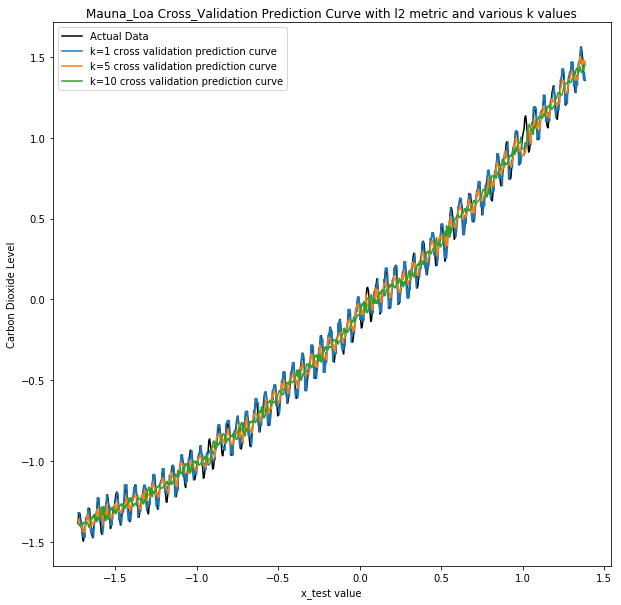

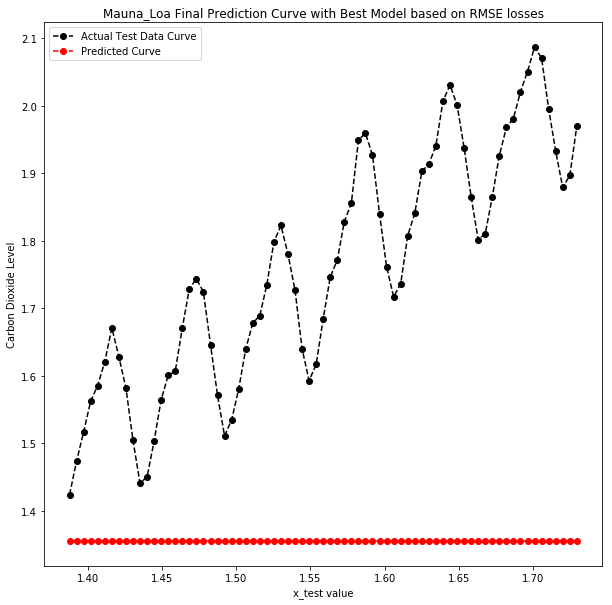

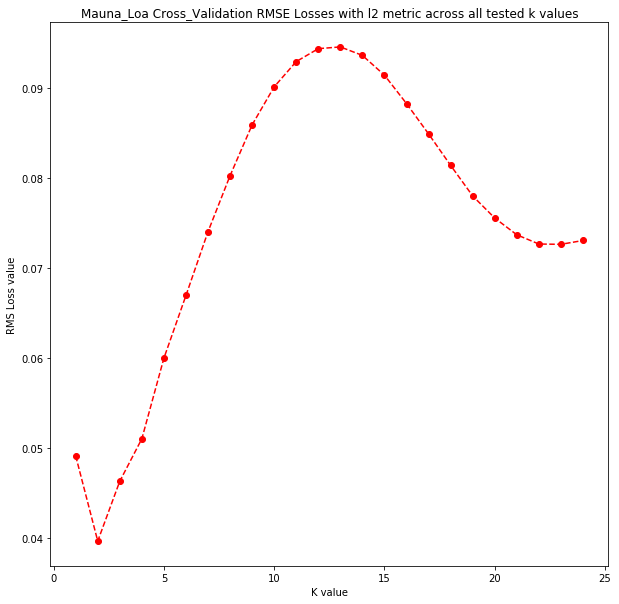

In [45]:
np.random.seed(100)
dataset_names = ['mauna_loa', 'rosenbrock']

for name in dataset_names:
    print("Following information is for the dataset: ", name)
    # these are the k values whose cross validation prediction curves will be plotted for mauna_loa 
    k_plot_list = [1, 5, 10]
    # load data 
    if name == 'rosenbrock':
        x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset(name, d=2, n_train=1000)
    else:
        x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset(name)
    # combine the train and valid sets for use in cross validation, since we're going to divide all of this data into 5 folds 
    x_train_orig = np.vstack([x_valid, x_train])
    y_train_orig = np.vstack([y_valid, y_train])
    # first plot the actual data for mauna_loa, this will be used to compare against 3 k value prediction curves mauna_loa
    # squeeze the x and y because they have the extra dimension of 1 after the size 
    if name == "mauna_loa": 
        plt.figure(figsize=(10,10))
        plt.plot(x_train_orig.squeeze(), y_train_orig.squeeze(), 'k', label='Actual Data')
    # introduce randomness by shuffling the x_train_orig and y_train_orig in unison
    x_train, y_train, p = reorder_data(x_train_orig, y_train_orig)
    # obtain the fold indices 
    fold_indices = produce_fold_indices(x_train)
    #create the k_choices 
    k_choices = np.arange(1, 25, dtype=int)
    # create the metrics array 
    metrics_array = np.array([1,2])
    # initialize the RMSE loss array
    RMSE_losses = np.zeros((k_choices.shape[0], metrics_array.shape[0]))

    # loop through the k values, for each k value apply both l1 and l2 metric 
    for k_index_in_RMSE, k_value in enumerate(k_choices):
        # loop through the 2 metrics, metric = 1 or 2 
        for metric_index_in_RMSE, metric in enumerate(metrics_array):
            # initialize the all_predictions array, 
            # which will contain all results of running prediction on all of the dataset values during cross validation for this particular metric, k configuration 
            all_predictions = np.zeros(x_train.shape[0]) 
            # obtain the current validation fold and training folds, loop over all 5 folds 
            for i in range(5):
                # special case when the validation fold is the final portion 
                if i == 4:
                    current_val_set_x = x_train[fold_indices[i]:] # for the last index, you just go from it to end of the dataset
                    # the rest of the data (from index 0 up to the last fold) will be for training 
                    current_train_set_x = x_train[:fold_indices[i]]
                    current_train_set_y = y_train[:fold_indices[i]]
                    # make prediction                
                    all_predictions[fold_indices[i]:] = K_NN_Regression_Brute(current_train_set_x, current_train_set_y, current_val_set_x, k=k_value, distance_metric=metric).squeeze()
                # general case when the validation fold is not the final portion 
                else:
                    current_val_set_x = x_train[fold_indices[i]:fold_indices[i+1]] 
                    # gather the rest of the data into training set
                    # in this case where the fold is not at the very beginning, you have to concatenate nonadjacent parts of the data  
                    if fold_indices[i] > 0:
                        current_train_set_x = np.concatenate((x_train[0:fold_indices[i]], x_train[fold_indices[i+1]:]), axis=0)
                        current_train_set_y = np.concatenate((y_train[0:fold_indices[i]], y_train[fold_indices[i+1]:]), axis=0)
                    # at the very beginning when the fold_index is 0 
                    else:
                        current_train_set_x = x_train[fold_indices[i+1]:]
                        current_train_set_y = y_train[fold_indices[i+1]:]
                    # make prediction 
                    all_predictions[fold_indices[i]:fold_indices[i+1]] = K_NN_Regression_Brute(current_train_set_x, current_train_set_y, current_val_set_x, k=k_value, distance_metric=metric).squeeze()
            # plot the cross validation prediction curve values (check that we're on metric 2 and the k value is what we want)
            if name == 'mauna_loa' and k_value in k_plot_list and metric == 2:
                k_plot_list.remove(k_value)
                # important to obtain the correct (original) ordering of the predictions 
                reordered_predictions = return_original_prediction_order(all_predictions, p)
                plt.plot(x_train_orig.squeeze(), reordered_predictions, label='k=%d cross validation prediction curve'%k_value) 
            # compute the RMSE loss values produced using this metric and k_value, and report it 
            RMSE_losses[k_index_in_RMSE, metric_index_in_RMSE] = np.sqrt(np.mean(np.square(all_predictions - y_train.squeeze())))
            #print("For k = %d and metric l_%d, the RMSE_loss is %.8f" % (k_value, metric, RMSE_losses[k_index_in_RMSE, metric_index_in_RMSE]))
        
    # now that cross validation is completed for all (k, metric) parameter configurations, find the parameter configuration with the smallest RMSE loss
    best_parameters, smallest_loss = find_best_parameters(RMSE_losses, k_choices, metrics_array)
    print("Tried with k values ranging from %d to %d"% (np.min(k_choices), np.max(k_choices)))
    print("The best parameter configuration for dataset {" + name + "} is k = %d and metric = 1_%d, with an RMSE loss of %.8f" % (best_parameters[0], best_parameters[1], smallest_loss))
    # apply the best parameters to the test set 
    predicted_test = K_NN_Regression_Brute(x_train, y_train, x_test, k=best_parameters[0], distance_metric=best_parameters[1]).squeeze()
    test_RMSE = np.sqrt(np.mean(np.square(predicted_test - y_test.squeeze())))
    print("The test RMSE with best parameters is: ", test_RMSE)

    # finalize plotting information for the mauna_loa dataset 
    if name == 'mauna_loa':
        # for the cross validation prediction curve 
        plt.title("Mauna_Loa Cross_Validation Prediction Curve with l2 metric and various k values")
        plt.legend(loc=0)
        plt.xlabel('x_test value')
        plt.ylabel('Carbon Dioxide Level')
        # for the final predictions on the untouched test set 
        plt.figure(figsize=(10,10))
        plt.title('Mauna_Loa Final Prediction Curve with Best Model based on RMSE losses')
        plt.plot(x_test.squeeze(), y_test.squeeze(), '--ko', label="Actual Test Data Curve")
        plt.plot(x_test.squeeze(), predicted_test, '--ro', label="Predicted Curve")
        plt.legend(loc=0)
        plt.xlabel('x_test value')
        plt.ylabel('Carbon Dioxide Level')
        # for the cross validation RMSE loss values 
        plt.figure(figsize=(10,10))
        plt.title('Mauna_Loa Cross_Validation RMSE Losses with l2 metric across all tested k values')
        plt.plot(k_choices, RMSE_losses[:, 1], '--ro')
        plt.xlabel('K value')
        plt.ylabel('RMS Loss value')

Made a separate cell to run the pumadyn32nm dataset because it takes too long and also seems to perform better with larger k values 

In [212]:
np.random.seed(100)
name = 'pumadyn32nm'
print("Following information is for the dataset: ", name)
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset(name)
x_train_orig = np.vstack([x_valid, x_train])
y_train_orig = np.vstack([y_valid, y_train])
x_train, y_train, p = reorder_data(x_train_orig, y_train_orig)
fold_indices = produce_fold_indices(x_train)
k_choices = np.arange(18, 29, dtype=int)
metrics_array = np.array([1,2])
RMSE_losses = np.zeros((k_choices.shape[0], metrics_array.shape[0]))

for k_index_in_RMSE, k_value in enumerate(k_choices):
    for metric_index_in_RMSE, metric in enumerate(metrics_array): 
        all_predictions = np.zeros(x_train.shape[0]) 
        for i in range(5):
            if i == 4:
                current_val_set_x = x_train[fold_indices[i]:] # for the last index, you just go from it to end of the dataset
                current_train_set_x = x_train[:fold_indices[i]]
                current_train_set_y = y_train[:fold_indices[i]]
                all_predictions[fold_indices[i]:] = K_NN_Regression_Brute(current_train_set_x, current_train_set_y, current_val_set_x, k=k_value, distance_metric=metric).squeeze()
            else:
                current_val_set_x = x_train[fold_indices[i]:fold_indices[i+1]] 
                if fold_indices[i] > 0:
                    current_train_set_x = np.concatenate((x_train[0:fold_indices[i]], x_train[fold_indices[i+1]:]), axis=0)
                    current_train_set_y = np.concatenate((y_train[0:fold_indices[i]], y_train[fold_indices[i+1]:]), axis=0)
                else:
                    current_train_set_x = x_train[fold_indices[i+1]:]
                    current_train_set_y = y_train[fold_indices[i+1]:]
                all_predictions[fold_indices[i]:fold_indices[i+1]] = K_NN_Regression_Brute(current_train_set_x, current_train_set_y, current_val_set_x, k=k_value, distance_metric=metric).squeeze()
        RMSE_losses[k_index_in_RMSE, metric_index_in_RMSE] = np.sqrt(np.mean(np.square(all_predictions - y_train.squeeze())))
        #print("For k = %d and metric l_%d, the RMSE_loss is %.8f" % (k_value, metric, RMSE_losses[k_index_in_RMSE, metric_index_in_RMSE]))    
best_parameters, smallest_loss = find_best_parameters(RMSE_losses, k_choices, metrics_array)
print("Tried with k values ranging from %d to %d"% (np.min(k_choices), np.max(k_choices)))
print("The best parameter configuration for dataset {" + name + "} is k = %d and metric = 1_%d, with an RMSE loss of %.8f" % (best_parameters[0], best_parameters[1], smallest_loss))
predicted_test = K_NN_Regression_Brute(x_train, y_train, x_test, k=best_parameters[0], distance_metric=best_parameters[1])
test_RMSE = np.sqrt(np.mean(np.square(predicted_test - y_test.squeeze())))
print("The test RMSE with best parameters is: ", test_RMSE)

********************************************************************************
Following information is for the dataset:  pumadyn32nm
Tried with k values ranging from 18 to 28
The best parameter configuration for dataset {pumadyn32nm} is k = 27 and metric = 1_1, with an RMSE loss of 0.87006231
The test RMSE with best parameters is:  1.0159095125675515


# Question 2: Test Performance Using K-D Tree

In [19]:
# define K_NN for regression algorithm, x_test contains multiple inputs 
def K_NN_Regression_Brute(x_train, y_train, x_test, k, distance_metric):
    # prediction will have same length as x_test, will be returned 
    predictions = np.zeros((x_test.shape[0], 1))
    i = 0 
    # loop through all the test points 
    for test_point in x_test:
        if distance_metric == 1:
            # use l1 distance  
            # apply reshape to ensure equal 2nd dimension as x_train is (__, 1)
            dist = np.sum(np.abs(x_train-test_point.reshape((1,-1))), axis=1) 
        elif distance_metric == 2:
            # use l2 distance 
            dist = np.sqrt(np.sum(np.square(x_train-test_point.reshape((1,-1))), axis=1))
        else:
            print('ERROR')
            return None
        # return the first nearest k point's indices 
        i_nn = np.argpartition(dist, kth=k)[:k]
        # calculate the mean of the y_train values for the k indices
        current_prediction = np.mean(y_train[i_nn])
        predictions[i, 0] = current_prediction
        i += 1 
    return predictions

# define K_NN regression function that uses KDTree instead of brute force 
def K_NN_Regression_KDTree(x_train, y_train, x_test, k):
    # create a KDTree data structure from the training set points  
    kd_tree = KDTree(x_train)
    # query the closest k neighbours of the test set
    # indices has shape (x_test.size, k)
    indices = kd_tree.query(x_test, k=k, return_distance=False, sort_results=False)
    # obtain the prediction as the mean of the labels for those k neighbours in the training set 
    # y_train[indices] has shape (x_test.size, k, 1), we want the mean over the 1 axis (5 neighbours) not the 0 axis (the 1000 test points)
    predictions = np.mean(y_train[indices], axis=1)
    return predictions

Verify that the Brute Force and KDTree methods are producing the same predictions. 

In [23]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('rosenbrock', d=5, n_train=5000)
brute_predictions = K_NN_Regression_Brute(x_train, y_train, x_test, k=5, distance_metric=2)
kdtree_predictions = K_NN_Regression_KDTree(x_train, y_train, x_test, k=5)
print(np.mean(brute_predictions - kdtree_predictions))

2.5594760685865302e-18


Conduct performance analysis for runtime comparisons between brute force and kdTree methods. I use d values from 2 to 10. 

Text(0,0.5,'runtime in s')

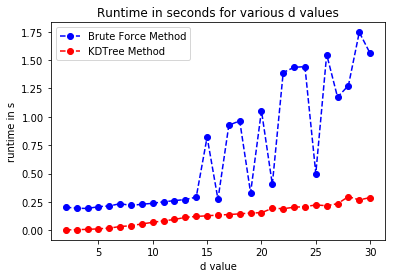

In [181]:
# initialize d values array and the runtime arrays 
d_array = np.arange(2,31, dtype=int)
brute_runtimes_for_ds = np.zeros(d_array.shape)
kdTree_runtimes_for_ds = np.zeros(d_array.shape)

# populate runtime array for brute force method 
for i, d_val in enumerate(d_array):
    # load dataset values 
    x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('rosenbrock', d=d_val, n_train=5000)
    # run brute force knn regression and record time elapsed 
    start_time = time.time()
    brute_predictions = K_NN_Regression_Brute(x_train, y_train, x_test, k=5, distance_metric=2)
    brute_runtimes_for_ds[i] = time.time() - start_time
    # run kdtree regression and record time elapsed 
    start_time = time.time()
    kdtree_predictions = K_NN_Regression_KDTree(x_train, y_train, x_test, k=5)
    kdTree_runtimes_for_ds[i] = time.time() - start_time

# plot the runtimes for varying d values 
plt.figure()
plt.title('Runtime in seconds for various d values')
plt.plot(d_array, brute_runtimes_for_ds, '--bo', label="Brute Force Method")
plt.plot(d_array, kdTree_runtimes_for_ds, '--ro', label="KDTree Method")
plt.legend(loc=0)
plt.xlabel('d value')
plt.ylabel('runtime in s')

# Question 3: Implement K-NN for Classification

In [2]:
# define KNN for classification function 
def K_NN_Classification_Brute(x_train, y_train, x_test, k, distance_metric):
    # prediction will have same length as x_test, will be returned 
    predictions = np.zeros((x_test.shape[0], 1))
    i = 0 
    # loop through all the test points 
    for test_point in x_test:
        if distance_metric == 1:
            # use l1 distance  
            # apply reshape to ensure equal 2nd dimension as x_train is (__, 1)
            dist = np.sum(np.abs(x_train-test_point.reshape((1,-1))), axis=1) 
        elif distance_metric == 2:
            # use l2 distance 
            dist = np.sqrt(np.sum(np.square(x_train-test_point.reshape((1,-1))), axis=1))
        else:
            print('ERROR')
            return None
        # obtain the sorted indices of the k nearest neighbours  
        i_nn = np.argsort(dist)[:k]
        # vote on number of occurrences of each class in the y_train labels array 
        vote, count = np.unique(y_train[i_nn], return_counts=True)
        # check of the max count value appears more than once in count array 
        if np.count_nonzero(count == np.max(count)) > 1:
            # we will choose the prediction as the value of the neighbour that has the shortest distance to the test point 
            predictions[i, 0] = y_train[i_nn[0]]
        else:
            predictions[i, 0] = vote[np.argmax(count)]
        i += 1 
    return predictions

# define K_NN classification function that uses KDTree instead of brute force 
def K_NN_Classification_KDTree(x_train, y_train, x_test, k, distance_metric):
    # create a KDTree data structure from the training set points, use the preferred distance metric 
    if distance_metric == 1:
        kd_tree = KDTree(x_train, metric='manhattan')
    elif distance_metric == 2:
        kd_tree = KDTree(x_train, metric='euclidean')
    predictions = np.zeros((x_test.shape[0], 1))
    # grab the k nearest neighbour indices for EACH test point 
    indices = kd_tree.query(x_test, k=k, return_distance=False, sort_results=True)
    # iterate through the neighbours for EACH test point, counting the occurences of the labels to find the most common label 
    for i, neighbour_indices in enumerate(indices):
        vote, count = np.unique(y_train[neighbour_indices], return_counts=True)
        if np.count_nonzero(count == np.max(count)) > 1:
            predictions[i, 0] = y_train[neighbour_indices[0]]
        else:
            predictions[i, 0] = vote[np.argmax(count)]
    return predictions

In [3]:
# function that produces the best parameters based on largest accuracy 
def find_most_accurate_parameters(accuracies, k_choices, metrics_array):
    biggest_accuracy = float(0)
    best_parameters = [0,0] #k, metric
    for index_k, k_val in enumerate(k_choices):
        for index_metric, metric in enumerate(metrics_array):
            if accuracies[index_k, index_metric] >= biggest_accuracy:
                biggest_accuracy = accuracies[index_k, index_metric]
                best_parameters = [k_val,metric]
    return best_parameters, biggest_accuracy
    
# convert the one-hot encodings to integer labels to allow the uniqueness counting to work in the K-nn classifier
def get_integer_labels(y):
    new_y = np.argmax(y, axis=1)
    new_y = np.expand_dims(new_y, axis=1)
    return new_y

In [4]:
np.random.seed(100)
def get_model_and_test(name, k_choices, knn_algorithm):
    """used to estimate for the best parameters and also run on the test set 

    @param name: the name of the dataset
    @param k_choices: the array of k values to test for
    @knn_algorithm: specifies which algorithm to use for knn 
    """
    print("Following information is for the dataset: ", name)
    x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset(name)

    # convert the one-hot encodings to integer labels to allow the uniqueness counting to work in the K-nn classifier
    y_train = get_integer_labels(y_train)
    y_valid = get_integer_labels(y_valid)
    y_test = get_integer_labels(y_test)

    metrics_array = np.array([1,2])
    accuracy_array= np.zeros((k_choices.shape[0], metrics_array.shape[0]))

    # the same process as in Part 1 is followed (nested for-loop to iterate over the metrics, enclosed in for-loop looping through the k values)
    for k_index, k_value in enumerate(k_choices):
        for metric_index, metric in enumerate(metrics_array):
            if knn_algorithm == 'brute':
                all_predictions = K_NN_Classification_Brute(x_train, y_train, x_valid, k_value, metric)
            elif knn_algorithm == 'kdtree':
                all_predictions = K_NN_Classification_KDTree(x_train, y_train, x_valid, k_value, metric)
  
            # compute the validation accuracy (average over all the validation point predictions)
            accuracy_array[k_index, metric_index] = np.count_nonzero(all_predictions == y_valid) / y_valid.size
            #print("For k = %d and metric l_%d, the validation accuracy is %.8f" % (k_value, metric, accuracy_array[k_index, metric_index]))
        
    # now that cross validation is completed for all (k, metric) parameter configurations, find the parameter configuration with the smallest RMSE loss
    best_parameters, largest_accuracy = find_most_accurate_parameters(accuracy_array, k_choices, metrics_array)
    print("Tried with k values ranging from %d to %d"% (np.min(k_choices), np.max(k_choices)))
    print("The best parameter configuration for dataset {" + name + "} is k = %d and metric = 1_%d, with an accuracy of %.8f" % (best_parameters[0], best_parameters[1], largest_accuracy))
    # apply the best parameters to the test set 
    if knn_algorithm == 'brute':
        predicted_test = K_NN_Classification_Brute(x_train, y_train, x_test, k=best_parameters[0], distance_metric=best_parameters[1])
    elif knn_algorithm == 'kdtree':
        predicted_test = K_NN_Classification_KDTree(x_train, y_train, x_test, k=best_parameters[0], distance_metric=best_parameters[1])      
    test_accuracy = np.count_nonzero(predicted_test == y_test) / y_test.size
    print("The test accuracy with best parameters is: ", test_accuracy)
    print('-'*100)

In [11]:
# run on the iris dataset
start_time = time.time()
get_model_and_test('iris', k_choices=np.arange(1, 25, dtype=int), knn_algorithm='brute')
print('Time in seconds:', time.time() - start_time)

Following information is for the dataset:  iris
Tried with k values ranging from 1 to 24
The best parameter configuration for dataset {iris} is k = 13 and metric = 1_2, with an accuracy of 0.90322581
The test accuracy with best parameters is:  1.0
----------------------------------------------------------------------------------------------------
Time in seconds: 0.10722970962524414


In [12]:
start_time = time.time()
get_model_and_test('iris', k_choices=np.arange(1, 25, dtype=int), knn_algorithm='kdtree')
print('Time in seconds:', time.time() - start_time)

Following information is for the dataset:  iris
Tried with k values ranging from 1 to 24
The best parameter configuration for dataset {iris} is k = 13 and metric = 1_2, with an accuracy of 0.90322581
The test accuracy with best parameters is:  1.0
----------------------------------------------------------------------------------------------------
Time in seconds: 0.07290196418762207


In [6]:
start_time = time.time()
# run on the mnist dataset, only use 1 to 6 as the k values to test for because mnist takes too long to run 
get_model_and_test('mnist_small', k_choices=np.arange(1, 7, dtype=int), knn_algorithm='brute')
print('Time in seconds:', time.time() - start_time)

Following information is for the dataset:  mnist_small
Tried with k values ranging from 1 to 6
The best parameter configuration for dataset {mnist_small} is k = 6 and metric = 1_2, with an accuracy of 0.95000000
The test accuracy with best parameters is:  0.948
----------------------------------------------------------------------------------------------------
Time in seconds: 1011.4610822200775


In [5]:
start_time = time.time()
get_model_and_test('mnist_small', k_choices=np.arange(1, 7, dtype=int), knn_algorithm='kdtree')
print('Time in seconds:', time.time() - start_time)

Following information is for the dataset:  mnist_small
Tried with k values ranging from 1 to 6
The best parameter configuration for dataset {mnist_small} is k = 6 and metric = 1_2, with an accuracy of 0.95000000
The test accuracy with best parameters is:  0.948
----------------------------------------------------------------------------------------------------
Time in seconds: 175.11619973182678


# Question 4: Implement Linear Regression Algorithm Minimizing Least-Squares Loss

In [41]:
# define the function that takes training data and labels and x_test, returns the predictions 
def linear_regression_svd(x_train, y_train, x_test):
    # introduce dummy feature by adding a ones' column to the features
    new_x_train = np.concatenate((np.ones((x_train.shape[0], 1)), x_train), axis=1)
    new_x_test = np.concatenate((np.ones((x_test.shape[0], 1)), x_test), axis=1)
    # perform SVD on the training features 
    U, s, Vh = np.linalg.svd(new_x_train, full_matrices=False, compute_uv=True)
    # compute the matrices that are used in the final computation of w
    V = Vh.transpose()
    # matrix new_x_train has alot more rows than columns 
    s_inv = np.linalg.inv(np.diag(s))
    U_trans = U.transpose()
    # compute the weights w using the formula presented in lecture
    w = np.dot(V, np.dot(s_inv, np.dot(U_trans, y_train)))
    # make the prediction by multiplying the testing data with the weights 
    predictions = np.dot(new_x_test, w)
    return predictions

# define evaludation functions 
def evaluate_RMSE(predictions, y_test):
    rmse = np.sqrt(np.mean(np.square(predictions - y_test)))
    return rmse 

def evaluate_accuracy(predictions, y_test):
    accuracy = np.count_nonzero(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / y_test.shape[0]
    return accuracy


In [42]:
# define the function to run the linear regression algorithm on a specific dataset 
def implement_regression(name, criterion):
    print('-'*100)
    print("Following information is for the dataset: ", name)
    if name=='rosenbrock':
        x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset(name, d=2, n_train=1000)
    else:
        x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset(name)
    # use both train and valid sets to build the model 
    x_train = np.vstack([x_valid, x_train])
    y_train = np.vstack([y_valid, y_train])
    # compute the predictions
    predictions = linear_regression_svd(x_train, y_train, x_test)
    if criterion == 'rmse':
        rmse = evaluate_RMSE(predictions, y_test)
        print("The RMSE loss on the test set is: %.8f" % rmse)
        return rmse
    elif criterion == 'accuracy':
        accuracy = evaluate_accuracy(predictions, y_test)
        print("The accuracy on the test set is: %.8f" % accuracy)
        return accuracy 
    else:
        print('WRONG EVALUATION CRITERION INPUT')
        return False     

In [43]:
# code block to run the linear regression algorithm on all datasets 
mauna_loa_rmse = implement_regression('mauna_loa', 'rmse')
rosenbrock_rmse = implement_regression('rosenbrock', 'rmse')
pumadyn32nm_rmse = implement_regression('pumadyn32nm', 'rmse')
iris_acc = implement_regression('iris', 'accuracy')
mnist_small_acc = implement_regression('mnist_small', 'accuracy')

----------------------------------------------------------------------------------------------------
Following information is for the dataset:  mauna_loa
The RMSE loss on the test set is: 0.34938831
----------------------------------------------------------------------------------------------------
Following information is for the dataset:  rosenbrock
The RMSE loss on the test set is: 0.98408720
----------------------------------------------------------------------------------------------------
Following information is for the dataset:  pumadyn32nm
The RMSE loss on the test set is: 0.86225124
----------------------------------------------------------------------------------------------------
Following information is for the dataset:  iris
The accuracy on the test set is: 0.86666667
----------------------------------------------------------------------------------------------------
Following information is for the dataset:  mnist_small
The accuracy on the test set is: 0.85100000
